In [2]:
BATCH_SIZE = 16
EPOCHS = 100
IMG_SIZE = (256, 256)
TRAIN_SIZE = 1273
VAL_SIZE = 548
TEST_SIZE = 1821

# Data preparation

In [3]:
!gdown --id 1CcKHH6981zwwJXWukA_QyfuhPKbM6MBA
!unzip data.zip

Downloading...
From: https://drive.google.com/uc?id=1CcKHH6981zwwJXWukA_QyfuhPKbM6MBA
To: /content/data.zip
399MB [00:02, 143MB/s]
Archive:  data.zip
   creating: data/
  inflating: data/.DS_Store          
  inflating: __MACOSX/data/._.DS_Store  
   creating: data/train/
   creating: data/val/
   creating: data/train/multiple_diseases/
  inflating: data/train/.DS_Store    
  inflating: __MACOSX/data/train/._.DS_Store  
   creating: data/train/healthy/
   creating: data/train/rust/
   creating: data/train/scab/
   creating: data/val/multiple_diseases/
  inflating: data/val/.DS_Store      
  inflating: __MACOSX/data/val/._.DS_Store  
   creating: data/val/healthy/
   creating: data/val/rust/
   creating: data/val/scab/
  inflating: data/train/multiple_diseases/Train_36.jpg  
  inflating: __MACOSX/data/train/multiple_diseases/._Train_36.jpg  
  inflating: data/train/multiple_diseases/Train_1664.jpg  
  inflating: __MACOSX/data/train/multiple_diseases/._Train_1664.jpg  
  inflating: data/

In [4]:
import tensorflow as tf
import keras
import numpy as np
import pandas as pd
from keras import optimizers
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, BatchNormalization, GlobalAveragePooling2D
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import Sequential, Model
import matplotlib.pyplot as plt
from sklearn.utils import class_weight
from skimage.transform import resize
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Load all data

In [5]:
all_datagen = ImageDataGenerator(rescale=1./255)
train_datagen = ImageDataGenerator(
        rotation_range=45,
        width_shift_range=0.2,
        height_shift_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')
test_datagen = ImageDataGenerator()

In [6]:
all_train_gen = all_datagen.flow_from_directory(
    directory='data/train/',
    target_size=IMG_SIZE,
    batch_size=TRAIN_SIZE,
    class_mode="categorical",
    seed=42
)
all_val_gen = all_datagen.flow_from_directory(
    directory='data/val/',
    target_size=IMG_SIZE,
    batch_size=VAL_SIZE,
    class_mode="categorical",
    seed=42
)

# load all data into memory
all_train_data = all_train_gen[0]
all_val_data = all_val_gen[0]

Found 1273 images belonging to 4 classes.
Found 548 images belonging to 4 classes.


## OverSampling

In [7]:
!pip install imbalanced-learn

In [8]:
from imblearn.over_sampling import RandomOverSampler

oversample = RandomOverSampler(sampling_strategy='minority')
train_data_idx = np.array([i for i in range(len(all_train_data[0]))]).reshape(-1,1)
X_over, y_over = oversample.fit_resample(train_data_idx, all_train_data[1].argmax(axis=1))

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [10]:
oversam_data = []
for i in X_over[len(all_train_data[0]):len(X_over)].reshape(-1):
    oversam_data += [all_train_data[0][i]]

oversam_train_data = np.array(list(all_train_data[0]) + oversam_data)
del all_train_data
del oversam_data

In [11]:
all_train_data = (oversam_train_data, tf.keras.utils.to_categorical(y_over, num_classes=4))
del oversam_train_data

## Data loader

In [18]:
saved_train_data = all_train_data

In [ ]:
# Restore
all_train_data = saved_train_data

In [23]:
train_generator = train_datagen.flow(all_train_data[0], all_train_data[1], batch_size=BATCH_SIZE)
val_generator = test_datagen.flow(all_val_data[0], all_val_data[1], batch_size=BATCH_SIZE)
STEP_SIZE_TRAIN = len(train_generator)
STEP_SIZE_VALID = len(val_generator)

# Model

Learning rate schedule: 1e-05 to 0.0008 to 1e-05


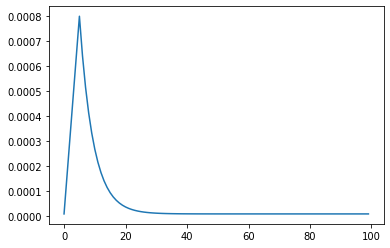

In [14]:
LR_START = 0.00001
LR_MAX = 0.0008
LR_MIN = 0.00001
LR_RAMPUP_EPOCHS = 5
LR_SUSTAIN_EPOCHS = 0
LR_EXP_DECAY = .8

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr

rng = [i for i in range(EPOCHS)]
y = [lrfn(x) for x in rng]
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

In [15]:
class CNN_Model(object):
    def __init__(self, trainable=True):
        self.batch_size = BATCH_SIZE
        self.trainable = trainable
        self.num_epochs = EPOCHS

        # Building model
        self._build_model()

        # Input data
        if trainable:
            self.model.summary()

        self.model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(), metrics=['accuracy'])

    def _build_model(self):
        # CNN model
        self.model = Sequential()
        self.model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)))
        self.model.add(BatchNormalization())
        self.model.add(Conv2D(64, (3, 3), activation='relu'))
        self.model.add(BatchNormalization())
        self.model.add(MaxPooling2D(pool_size=(2, 2)))

        self.model.add(Conv2D(64, (3, 3), activation='relu'))
        self.model.add(BatchNormalization())
        self.model.add(Conv2D(64, (3, 3), activation='relu'))
        self.model.add(BatchNormalization())
        self.model.add(Conv2D(64, (3, 3), activation='relu'))
        self.model.add(BatchNormalization())
        self.model.add(Conv2D(64, (3, 3), activation='relu'))
        self.model.add(BatchNormalization())
        self.model.add(MaxPooling2D(pool_size=(2, 2)))

        self.model.add(Conv2D(128, (3, 3), activation='relu'))
        self.model.add(BatchNormalization())
        self.model.add(Conv2D(128, (3, 3), activation='relu'))
        self.model.add(BatchNormalization())
        self.model.add(Conv2D(128, (3, 3), activation='relu'))
        self.model.add(BatchNormalization())
        self.model.add(Conv2D(128, (3, 3), activation='relu'))
        self.model.add(BatchNormalization())
        self.model.add(MaxPooling2D(pool_size=(2, 2)))

        self.model.add(Conv2D(128, (3, 3), activation='relu'))
        self.model.add(BatchNormalization())
        self.model.add(Conv2D(128, (3, 3), activation='relu'))
        self.model.add(BatchNormalization())
        self.model.add(Conv2D(128, (3, 3), activation='relu'))
        self.model.add(BatchNormalization())
        self.model.add(Conv2D(128, (3, 3), activation='relu'))
        self.model.add(BatchNormalization())
        self.model.add(MaxPooling2D(pool_size=(2, 2)))

        self.model.add(Conv2D(256, (3, 3), activation='relu'))
        self.model.add(BatchNormalization())
        self.model.add(Conv2D(256, (3, 3), activation='relu'))
        self.model.add(BatchNormalization())
        self.model.add(GlobalAveragePooling2D())

        self.model.add(Flatten())
        self.model.add(Dense(512, activation='relu'))
        self.model.add(BatchNormalization())
        self.model.add(Dense(4, activation='softmax'))

    def train(self):
        # schedule learning rate
        lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)
        # Model Checkpoint
        cpt_save = ModelCheckpoint('pretrained_myCNN.h5', save_best_only=True, monitor='val_accuracy', mode='max')

        early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, min_delta=0.001, mode='max')

        print("Training......")

        self.model.fit(train_generator,
                       steps_per_epoch=STEP_SIZE_TRAIN,
                       validation_data=val_generator,
                       validation_steps=STEP_SIZE_VALID,
                       callbacks=[cpt_save, lr_callback, early_stopping], verbose=1,
                       epochs=self.num_epochs)

In [16]:
cnn_model = CNN_Model(trainable=True)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 64)      1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 254, 254, 64)      256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 252, 252, 64)      36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 252, 252, 64)      256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 126, 126, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 124, 124, 64)      36928     
_________________________________________________________________
batch_normalization_2 (Batch (None, 124, 124, 64)      2

In [17]:
# Train with oversampled data
cnn_model.train()

Training......
Epoch 1/100

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
103/103 [==============================] - 72s 341ms/step - loss: 1.7075 - accuracy: 0.3070 - val_loss: 1.4389 - val_accuracy: 0.2427
Epoch 2/100

Epoch 00002: LearningRateScheduler reducing learning rate to 0.000168.
103/103 [==============================] - 30s 294ms/step - loss: 1.5937 - accuracy: 0.3435 - val_loss: 2.0954 - val_accuracy: 0.2828
Epoch 3/100

Epoch 00003: LearningRateScheduler reducing learning rate to 0.000326.
103/103 [==============================] - 31s 300ms/step - loss: 1.5086 - accuracy: 0.3398 - val_loss: 3.1716 - val_accuracy: 0.0511
Epoch 4/100

Epoch 00004: LearningRateScheduler reducing learning rate to 0.000484.
103/103 [==============================] - 30s 294ms/step - loss: 1.4193 - accuracy: 0.3720 - val_loss: 4.9432 - val_accuracy: 0.0602
Epoch 5/100

Epoch 00005: LearningRateScheduler reducing learning rate to 0.000642.
103/103 [=======================

In [19]:
# Original data
all_train_data = (all_train_data[0][:1273], all_train_data[1][:1273])
all_train_data[0].shape

(1273, 256, 256, 3)

In [ ]:
train_generator = train_datagen.flow(all_train_data[0], all_train_data[1], batch_size=BATCH_SIZE)
val_generator = test_datagen.flow(all_val_data[0], all_val_data[1], batch_size=BATCH_SIZE)
STEP_SIZE_TRAIN = len(train_generator)
STEP_SIZE_VALID = len(val_generator)

In [22]:
cnn_model.model.load_weights('pretrained_myCNN.h5')

In [24]:
# Continue training with original data
cnn_model.train()

Training......
Epoch 1/100

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
80/80 [==============================] - 23s 289ms/step - loss: 0.4980 - accuracy: 0.8185 - val_loss: 0.4596 - val_accuracy: 0.8613
Epoch 2/100

Epoch 00002: LearningRateScheduler reducing learning rate to 0.000168.
80/80 [==============================] - 24s 304ms/step - loss: 0.7151 - accuracy: 0.7423 - val_loss: 0.8053 - val_accuracy: 0.8157
Epoch 3/100

Epoch 00003: LearningRateScheduler reducing learning rate to 0.000326.
80/80 [==============================] - 24s 294ms/step - loss: 0.7124 - accuracy: 0.7526 - val_loss: 1.5050 - val_accuracy: 0.6569
Epoch 4/100

Epoch 00004: LearningRateScheduler reducing learning rate to 0.000484.
80/80 [==============================] - 24s 293ms/step - loss: 0.7033 - accuracy: 0.7628 - val_loss: 8.8829 - val_accuracy: 0.3431
Epoch 5/100

Epoch 00005: LearningRateScheduler reducing learning rate to 0.000642.
80/80 [==============================] -

# Test

In [25]:
!gdown --id 1hSUUxRxAg0xzZ2O1v5YPWsACGv_7uU0T
!gdown --id 1J0yfP08I3fYvIAMF02nz9H7NcArTxkag
!unzip test.zip

Downloading...
From: https://drive.google.com/uc?id=1hSUUxRxAg0xzZ2O1v5YPWsACGv_7uU0T
To: /content/test.zip
420MB [00:03, 134MB/s]
Downloading...
From: https://drive.google.com/uc?id=1J0yfP08I3fYvIAMF02nz9H7NcArTxkag
To: /content/test.csv
100% 17.1k/17.1k [00:00<00:00, 14.6MB/s]
Archive:  test.zip
   creating: test/
  inflating: test/.DS_Store          
  inflating: __MACOSX/test/._.DS_Store  
   creating: test/test/
  inflating: test/test/Test_588.jpg  
  inflating: __MACOSX/test/test/._Test_588.jpg  
  inflating: test/test/Test_1270.jpg  
  inflating: __MACOSX/test/test/._Test_1270.jpg  
  inflating: test/test/Test_1516.jpg  
  inflating: __MACOSX/test/test/._Test_1516.jpg  
  inflating: test/test/Test_1502.jpg  
  inflating: __MACOSX/test/test/._Test_1502.jpg  
  inflating: test/test/Test_1264.jpg  
  inflating: __MACOSX/test/test/._Test_1264.jpg  
  inflating: test/test/Test_239.jpg  
  inflating: __MACOSX/test/test/._Test_239.jpg  
  inflating: test/test/Test_211.jpg  
  inflating

In [26]:
test_model = CNN_Model(trainable=False).model
test_model.load_weights('pretrained_myCNN.h5')

In [27]:
# Load all data
all_test_gen = all_datagen.flow_from_directory(
    directory='test/',
    target_size=IMG_SIZE,
    batch_size=TEST_SIZE,
    class_mode='binary',
    shuffle=False
)
all_test_data = all_test_gen[0]

Found 1821 images belonging to 1 classes.


In [29]:
test_generator = test_datagen.flow(all_test_data[0], all_test_data[1], batch_size=BATCH_SIZE, shuffle=False)

result = []
for k in range(len(test_generator)):
    res = test_model.predict(test_generator[k][0])
    result += list(res)
result = np.array(result)
rnd_res = result.round(2)

In [30]:
submission = pd.DataFrame(data=rnd_res, columns=['healthy', 'multiple_diseases', 'rust', 'scab'])
submission.insert(loc=0, column='image_id', value=all_test_gen.filenames)
submission.image_id = submission.image_id.str.split('/').str[1].str.split('.').str[0]

df = pd.read_csv('test.csv')
submission = pd.merge(df, submission, on=['image_id'])
submission

,image_id,healthy,multiple_diseases,rust,scab
0,Test_0,0.00,0.04,0.96,0.00
1,Test_1,0.01,0.06,0.92,0.01
2,Test_2,0.01,0.00,0.00,0.99
3,Test_3,0.99,0.00,0.00,0.00
4,Test_4,0.00,0.02,0.98,0.00
...,...,...,...,...,...
1816,Test_1816,0.00,0.00,1.00,0.00
1817,Test_1817,0.00,0.03,0.00,0.97
1818,Test_1818,0.01,0.01,0.98,0.00
1819,Test_1819,1.00,0.00,0.00,0.00


In [31]:
submission.to_csv('submission.csv',index=False)